# Analysis of conservation scores
- looking at phastcon scores derived from pickle clip analysis files.

# Questions we want answered:
- Are regions of binding more conserved globally among all RBPs? 
 - yes... sometimes/most of the time. Peaks are generally more conserved, although for some RBPs there is less conservation.
- Which RBPs are more conserved?
 - which are not? is there anything special about these RBPs/peaks?
- which regions are more conserved?
 - look at fold change above shuffled background for each region

# Look at mean conservation for each peak above background 

In [1]:
%matplotlib inline
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import pandas as pd
from collections import defaultdict
from tqdm import tnrange, tqdm_notebook
import numpy as np
from encode import manifest_helpers
from density import ReadDensity

MIN_EVENTS = 1000

# Set min events to exclude LARP7, DKC1, BOP1
- per discussion w/ Gabe, these RBPs bind specifically to select regions and screw up the global analysis.

In [2]:
def read_filter(fn, p=3, f=3):
    """
    Reads and filters the input normalized peak files
    """
    df = pd.read_table(fn, names=['chrom','start','stop','name','score','strand'])
    df = df[(df['name']>=p) & (df['score']>=f)]
    print(df.shape)

In [3]:
pickle_loc = '/projects/ps-yeolab3/encode/analysis/encode_idr_clip_analysis/'
pickles = glob.glob(os.path.join(pickle_loc, '*IDR.out.0102merged.bed.annotated.clip_formatted.bed.clip_analysis.pickle'))
pickles[:3]

['/projects/ps-yeolab3/encode/analysis/encode_idr_clip_analysis/584.01v02.IDR.out.0102merged.bed.annotated.clip_formatted.bed.clip_analysis.pickle',
 '/projects/ps-yeolab3/encode/analysis/encode_idr_clip_analysis/571.01v02.IDR.out.0102merged.bed.annotated.clip_formatted.bed.clip_analysis.pickle',
 '/projects/ps-yeolab3/encode/analysis/encode_idr_clip_analysis/662.01v02.IDR.out.0102merged.bed.annotated.clip_formatted.bed.clip_analysis.pickle']

In [4]:
manifest = '/home/bay001/projects/maps_20160420/permanent_data/ALLDATASETS.txt'
# manifest = '/home/bay001/projects/encode/analysis/conservation_analysis/uid_to_rbpinfo_from_gabe_manifest.txt'
manifest_df = pd.read_table(manifest)

def uid_to_label(uid, df=manifest_df):
    """
    From a UID, return a nice label containing 
    the RBP name and cell type
    """
    _, _, _, rbp, cell = manifest_helpers.get_clip_file_from_uid(
        manifest_df,
        uid, 
        uid_col='uID',
        rbp_col='RBP',
        clip_r1_col='CLIP',
        clip_r2_col='CLIP',
        input_col='INPUT'
    )
    if cell is None and rbp is None:
        return ''
    return '{}-{}-{}'.format(uid, rbp, cell)
uid_to_label('534')

''

In [5]:
def format_filename_to_nicename(fn):
    """
    Returns a shorter but still unique label given a pickle filename
    """
    fil1 = os.path.basename(fn)
    return fil1

def get_dataframes(p):
    """
    From a clip_analysis pickle file, return two lists of dataframes
    containing the avg phastcon scores for each peak, for each
    region. For both real and random conditions, these will be lists
    even though the len(real_dfs) will always be one.
    
    returns :
        real_dfs : {'cds':[phastcon dataframe1], 'three_prime_utr':[phastcon dataframe1], ...}
        rand_dfs : {'cds':[df1, df2, df3], 'three_prime_utr':[df1, df2, df3], ...}
        
    """
    # loaded = pickle.load(open(p, 'rb'))  # this command breaks when using different version of pandas
    loaded = pd.read_pickle(p) 
    real_dfs = defaultdict(list)
    rand_dfs = defaultdict(list)
    
    for category, df in loaded['phast_values'].groupby(level=0):
        for real_rand, new_df in df.groupby(level=1):
            if real_rand == 'real':
                real_dfs[category].append(new_df)
            elif real_rand == 'rand':
                rand_dfs[category].append(new_df)
            else:
                print("warning: labels don't match what we expect: {}".format(real_rand))
                
    return real_dfs, rand_dfs

def get_mean_phastcon(lst, v=False, min_events=MIN_EVENTS):
    """
    returns mean phastcon score for all dataframes in list using 'mean' column.
    
    lst : list[df1, df2, df3, ...]
    v : boolean
        if True, verbose
    returns :
        mean : average phastcon value over all dataframes in list or nan if it doesn't pass threshold.
    """
    summed = 0
    num_events = 0
    for l in lst: # for each dataframe 
        summed = summed + l['mean'].sum()  # add mean values to the running sum 
        num_events = num_events + l.shape[0]  # add the number of events to the running total
    if v:
        print(num_events)
    if num_events < min_events:
        return np.nan
    return summed/float(num_events)

def l2_fold_change(real, rand):
    """
    Returns the log2 fold change of real 
    (real mean phastcon)/rand (mean phastcon over random event)
    """
    return np.log2(real/rand)

# Create dataframe of fold changes for each region, for each IDR peak file.
- also create dataframe of the mean phastcon values for later use/debug/etc.

In [6]:
merged_fold_changes = pd.DataFrame()
merged_means_real = pd.DataFrame()
merged_means_rand = pd.DataFrame()

to_exclude = ['243','298','544','553','516'] # LARP7, DKC1, BOP1

progress = tnrange(len(pickles))

for p in pickles:  # for each pickle file/RBP
    ### this block corresponds to a single line in merged dataframes, each line is a sample ###
    uid = os.path.basename(p).split('.')[0] # assumes a specific IDR filename structure... 
    label = uid_to_label(uid)
    if label != '':  # we found a submitted dataset with proper rbp/cell line annotations
        mean_real_dict = defaultdict()
        mean_rand_dict = defaultdict()
        fold_changes_dict = defaultdict()

        real, rand = get_dataframes(p) # get list of dataframes for each real/rand
        
        ### this block checks the number of events for the RBPs we want to exclude.
        if uid in to_exclude:
            print('{}, {}, '.format(uid, label)),
            get_mean_phastcon(real['all'], v=True)
        for region in rand.keys():  # for each cds, three_prime_utr, etc.

            ### get mean phastcon scores over list of dataframes in real/rand
            mean_real = get_mean_phastcon(real[region])
            mean_rand = get_mean_phastcon(rand[region])
            
                
            ### store values into dictionary 
            mean_real_dict[region] = mean_real
            mean_rand_dict[region] = mean_rand
            fold_changes_dict[region] = l2_fold_change(mean_real, mean_rand)

        ### Concatenate current line into merged
        merged_fold_changes = pd.concat(
            [merged_fold_changes, pd.DataFrame(fold_changes_dict, index=[label])], 
            axis=0
        )
        merged_means_real = pd.concat(
            [merged_means_real, pd.DataFrame(mean_real_dict, index=[label])]
        )
        merged_means_rand = pd.concat(
            [merged_means_rand, pd.DataFrame(mean_rand_dict, index=[label])]
        )
    progress.update(1)

HBox(children=(IntProgress(value=0, max=325), HTML(value=u'')))

553, 553-NOLC1-HepG2,  577
516, 516-NOLC1-K562,  1073
243, 243-LARP7-K562,  55
544, 544-DKC1-HepG2,  962
298, 298-LARP7-HepG2,  112


In [36]:
merged_means_real.head()

,all,cds,distintron500,five_prime_utrs,proxintron500,three_prime_utrs
584-TBRG4-K562,NaN,NaN,NaN,NaN,NaN,NaN
571-FUBP3-HepG2,0.588207,NaN,NaN,NaN,NaN,0.638686
414-PPIL4-K562,NaN,NaN,NaN,NaN,NaN,NaN
275-CSTF2T-K562,0.132822,NaN,0.092343,NaN,0.142589,NaN
280-AUH-HepG2,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
merged_means_rand.head()

,all,cds,distintron500,five_prime_utrs,proxintron500,three_prime_utrs
584-TBRG4-K562,NaN,NaN,NaN,NaN,NaN,NaN
571-FUBP3-HepG2,0.246061,NaN,NaN,NaN,NaN,0.263308
414-PPIL4-K562,0.178735,NaN,NaN,NaN,NaN,NaN
275-CSTF2T-K562,0.107443,NaN,0.077998,NaN,0.099186,NaN
280-AUH-HepG2,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
# merged_fold_changes
merged_means_rand.ix['571-FUBP3-HepG2']

/home/bay001/anaconda2/envs/brian/lib/python2.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


all                 0.246061
cds                      NaN
distintron500            NaN
five_prime_utrs          NaN
proxintron500            NaN
three_prime_utrs    0.263308
Name: 571-FUBP3-HepG2, dtype: float64

In [8]:
# sort by the highest log2 fold change (sum across all regions, including all)
merged_fold_changes['sum'] = 0  # incase I need to re-run and don't want the sum to include old sums
merged_fold_changes['sum'] = merged_fold_changes.sum(axis=1)
merged_fold_changes.sort_values(by='sum', ascending=False, inplace=True)

In [9]:
merged_fold_changes.to_csv(
    '/home/bay001/projects/encode/analysis/conservation_analysis/analysis_from_pickle/l2_fold_change_phastcons_from_pickle.txt', 
    sep='\t'
)
merged_means_real.to_csv(
    '/home/bay001/projects/encode/analysis/conservation_analysis/analysis_from_pickle/mean_phastcons_from_real_pickle.txt', 
    sep='\t'
)
merged_means_rand.to_csv(
    '/home/bay001/projects/encode/analysis/conservation_analysis/analysis_from_pickle/mean_phastcons_from_rand_pickle.txt', 
    sep='\t'
)

# plot the top most conserved RBPs for each condition

0

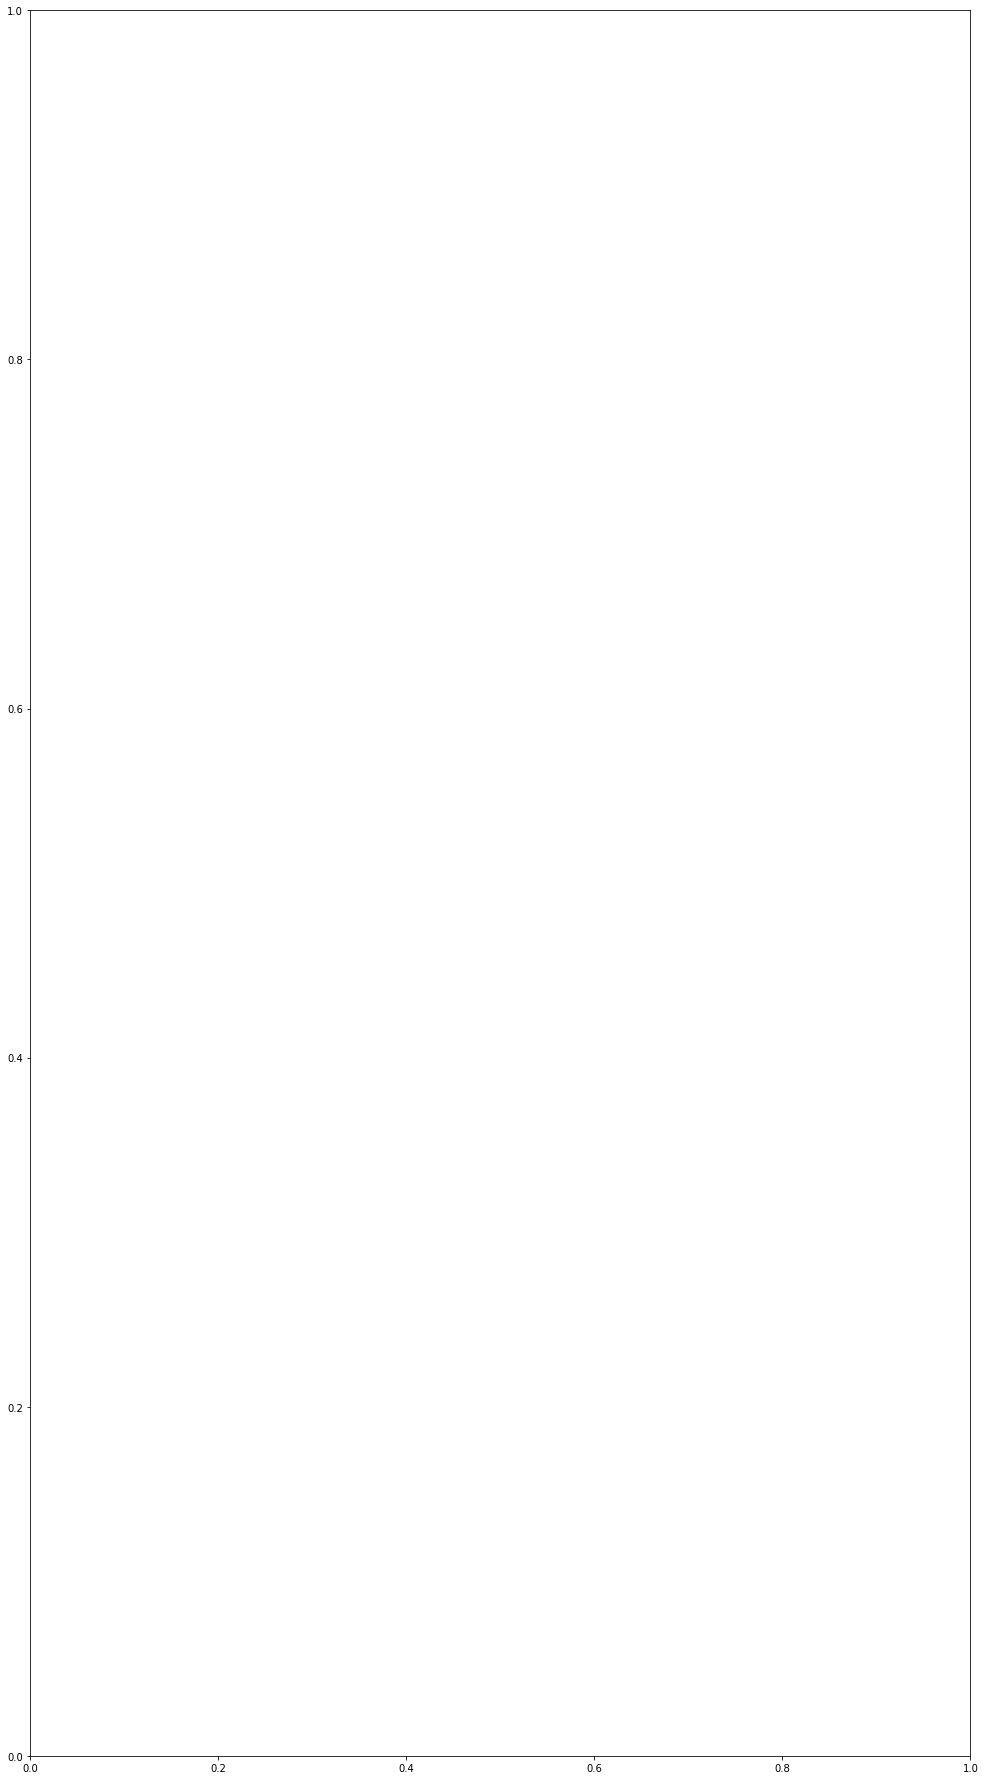

In [50]:
img_dir = '/home/bay001/projects/encode/analysis/conservation_analysis/analysis_from_pickle/'

regions = ['all','three_prime_utrs','five_prime_utrs','cds','distintron500','proxintron500']
num_to_plot = 50

# merged_fold_changes.index = [i.replace('.clip_formatted.bed.clip_analysis.pickle','') for i in merged.index] # cleans up the labels a bit more.
def plot_all_regions(df, regions, img_dir):
    for region in regions:
        # sort by the region specified (highest first), then take first num_to_plot
        df.sort_values(by=region, ascending=False, inplace=True)
        subset = df[:num_to_plot][region].dropna(how='all')
        subset = subset.iloc[::-1] # flip so that highest is on top
        subset.plot(
            kind='barh', 
            figsize=(15,25),
        )
        plt.title('Mean phastcon fold changes at least {} peaks: {}'.format(MIN_EVENTS, region))
        plt.tight_layout()
        plt.savefig(
            os.path.join(img_dir, '{}_mean_phastcon_l2_foldchanges.png'.format(region))
        )
        
        plt.clf()
        plt.cla()
    return 0

plot_all_regions(merged_fold_changes, regions, img_dir)

# independently check some of the outliers
- 225 looks a little high.. oh because I didn't check for minimum peak numbers. Fixed.
- 495 is pretty high, let's check the "ALL" area

In [11]:
p = '/projects/ps-yeolab3/encode/analysis/encode_idr_clip_analysis/495.01v02.IDR.out.0102merged.bed.annotated.clip_formatted.bed.clip_analysis.pickle'
# loaded = pickle.load(open(p, 'rb'))
loaded = pd.read_pickle(p)

In [12]:
mean_real = loaded['phast_values'].ix['all'].ix['real'].ix[1]['mean'].mean()
phastsum_rand1 = loaded['phast_values'].ix['all'].ix['rand'].ix[0]['mean'].sum()
sum_rand1 = loaded['phast_values'].ix['all'].ix['rand'].ix[0].shape[0]
phastsum_rand2 = loaded['phast_values'].ix['all'].ix['rand'].ix[1]['mean'].sum()
sum_rand2 = loaded['phast_values'].ix['all'].ix['rand'].ix[1].shape[0]
phastsum_rand3 = loaded['phast_values'].ix['all'].ix['rand'].ix[2]['mean'].sum()
sum_rand3 = loaded['phast_values'].ix['all'].ix['rand'].ix[2].shape[0]

sum_all = phastsum_rand1 + phastsum_rand2 + phastsum_rand3
n_all = sum_rand1 + sum_rand2 + sum_rand3

mean_rand = sum_all/float(n_all)
print(mean_real/mean_rand)
print(np.log2((mean_real/mean_rand)))
merged_fold_changes.ix['495-PPIG-HepG2']

1.22725761629
0.295438120014


/home/bay001/anaconda2/envs/brian/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.
/home/bay001/anaconda2/envs/brian/lib/python2.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
/home/bay001/anaconda2/envs/brian/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This i

all                 0.295438
cds                 0.257611
distintron500            NaN
five_prime_utrs          NaN
proxintron500            NaN
three_prime_utrs         NaN
sum                 0.553049
Name: 495-PPIG-HepG2, dtype: float64


# Plot heatmap of values
- nans cause problems?

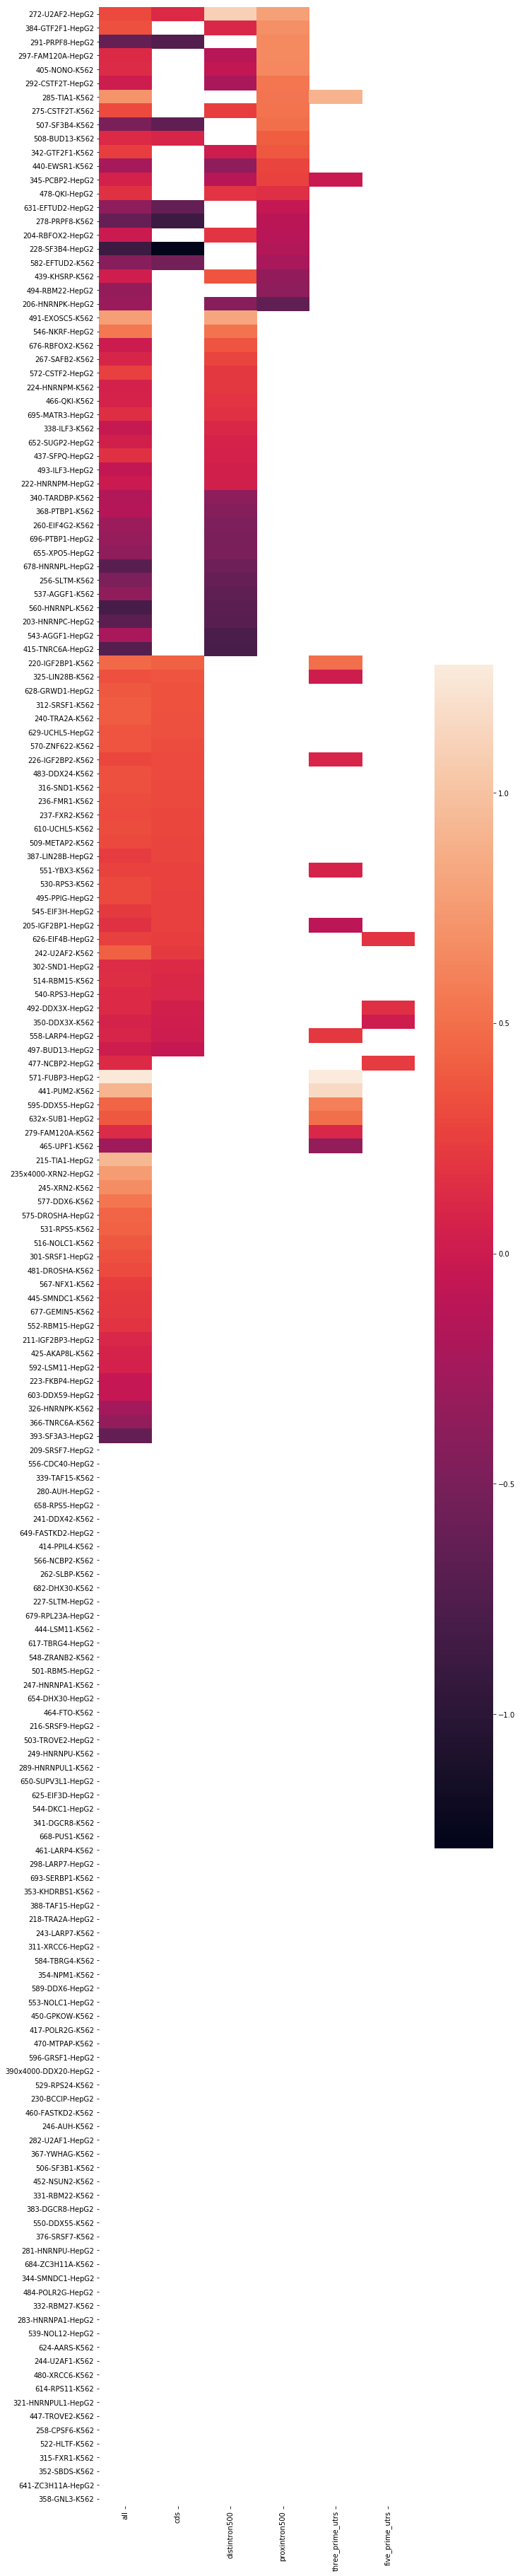

In [13]:
fig, ax = plt.subplots(figsize=(10,65))
to_plot = merged_fold_changes[['all','cds','distintron500','proxintron500','three_prime_utrs','five_prime_utrs']]
sns.heatmap(to_plot, ax=ax)
plt.savefig('/home/bay001/projects/encode/analysis/conservation_analysis/analysis_from_pickle/fold_change_phastcons_heatmap.svg')

In [14]:
# look at distal intron enriched conservation for splicing factors U2AF2/1, SF3B4, PRPF8
# look at 3' UTR enriched conservation for TDP43
# plot histogram of conservation scores
# convert to zscore

# Plot histogram of the conservation scores

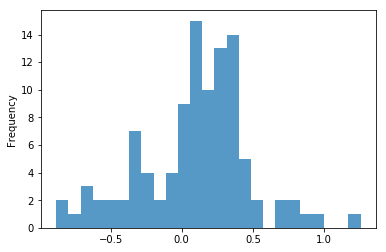

In [15]:
merged_fold_changes['all'].plot(kind='hist', bins=25, label='all', alpha=0.75)

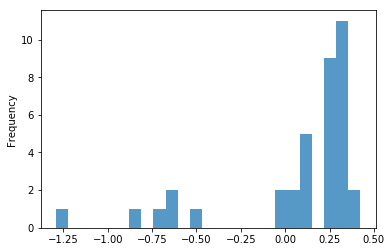

In [16]:
merged_fold_changes['cds'].plot(kind='hist', bins=25, label='cds', alpha=0.75)

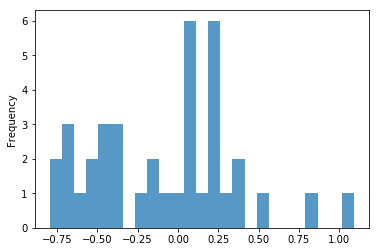

In [17]:
merged_fold_changes['distintron500'].plot(kind='hist', bins=25, label='distintron', alpha=0.75)

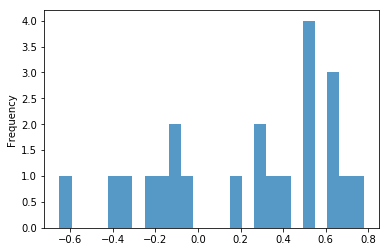

In [18]:
merged_fold_changes['proxintron500'].plot(kind='hist', bins=25, label='proxintron', alpha=0.75)

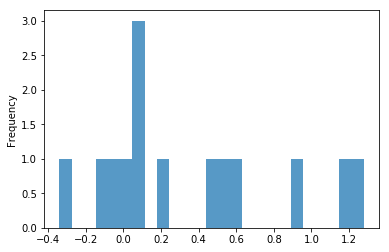

In [19]:
merged_fold_changes['three_prime_utrs'].plot(kind='hist', bins=25, label='3UTR', alpha=0.75)

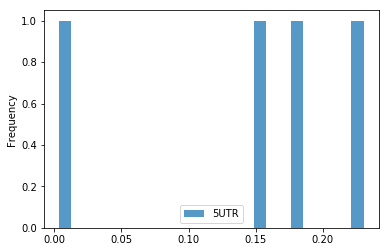

In [20]:
merged_fold_changes['five_prime_utrs'].plot(kind='hist', bins=25, label='5UTR', alpha=0.75)
plt.legend()

# Plot the z score as histogram

In [42]:
merged_fold_changes.head()

,all,cds,distintron500,five_prime_utrs,proxintron500,three_prime_utrs,sum
272-U2AF2-HepG2,0.303747,0.121695,1.092361,NaN,0.778605,NaN,2.296408
384-GTF2F1-HepG2,0.337942,NaN,0.110483,NaN,0.684705,NaN,1.133131
291-PRPF8-HepG2,-0.624890,-0.731238,NaN,NaN,0.651276,NaN,-0.704853
297-FAM120A-HepG2,0.121957,NaN,-0.135114,NaN,0.649324,NaN,0.636168
405-NONO-K562,0.130114,NaN,-0.065782,NaN,0.642371,NaN,0.706702


In [48]:
merged_fold_changes.std()

all                 0.384262
cds                 0.408555
distintron500       0.443727
five_prime_utrs     0.097938
proxintron500       0.413862
three_prime_utrs    0.486049
sum                 0.631297
dtype: float64

In [49]:
merged_fold_changes_z.ix['571-FUBP3-HepG2']

/home/bay001/anaconda2/envs/brian/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


all                 3.013955
cds                      NaN
distintron500            NaN
five_prime_utrs          NaN
proxintron500            NaN
three_prime_utrs    1.902765
sum                 3.840978
Name: 571-FUBP3-HepG2, dtype: float64

/home/bay001/anaconda2/envs/brian/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


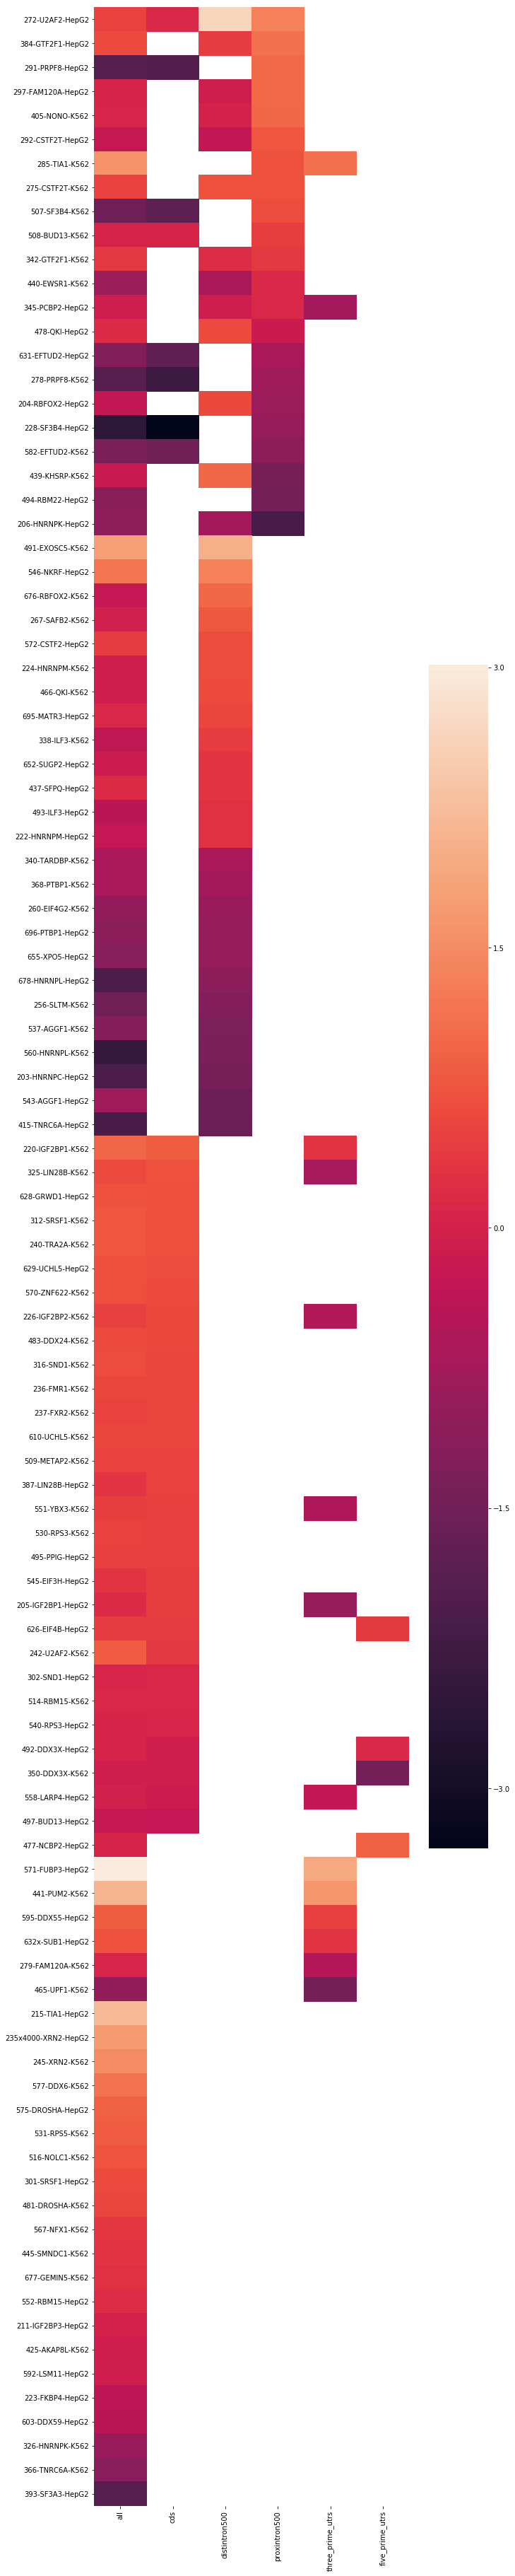

In [32]:
merged_fold_changes_z = (merged_fold_changes - merged_fold_changes.mean())/merged_fold_changes.std()

fig, ax = plt.subplots(figsize=(10,65))
to_plot = merged_fold_changes_z[['all','cds','distintron500','proxintron500','three_prime_utrs','five_prime_utrs']]
to_plot.dropna(how='all', inplace=True)
sns.heatmap(to_plot, ax=ax)
plt.savefig('/home/bay001/projects/encode/analysis/conservation_analysis/analysis_from_pickle/fold_change_phastcons_heatmap_zscore.svg')

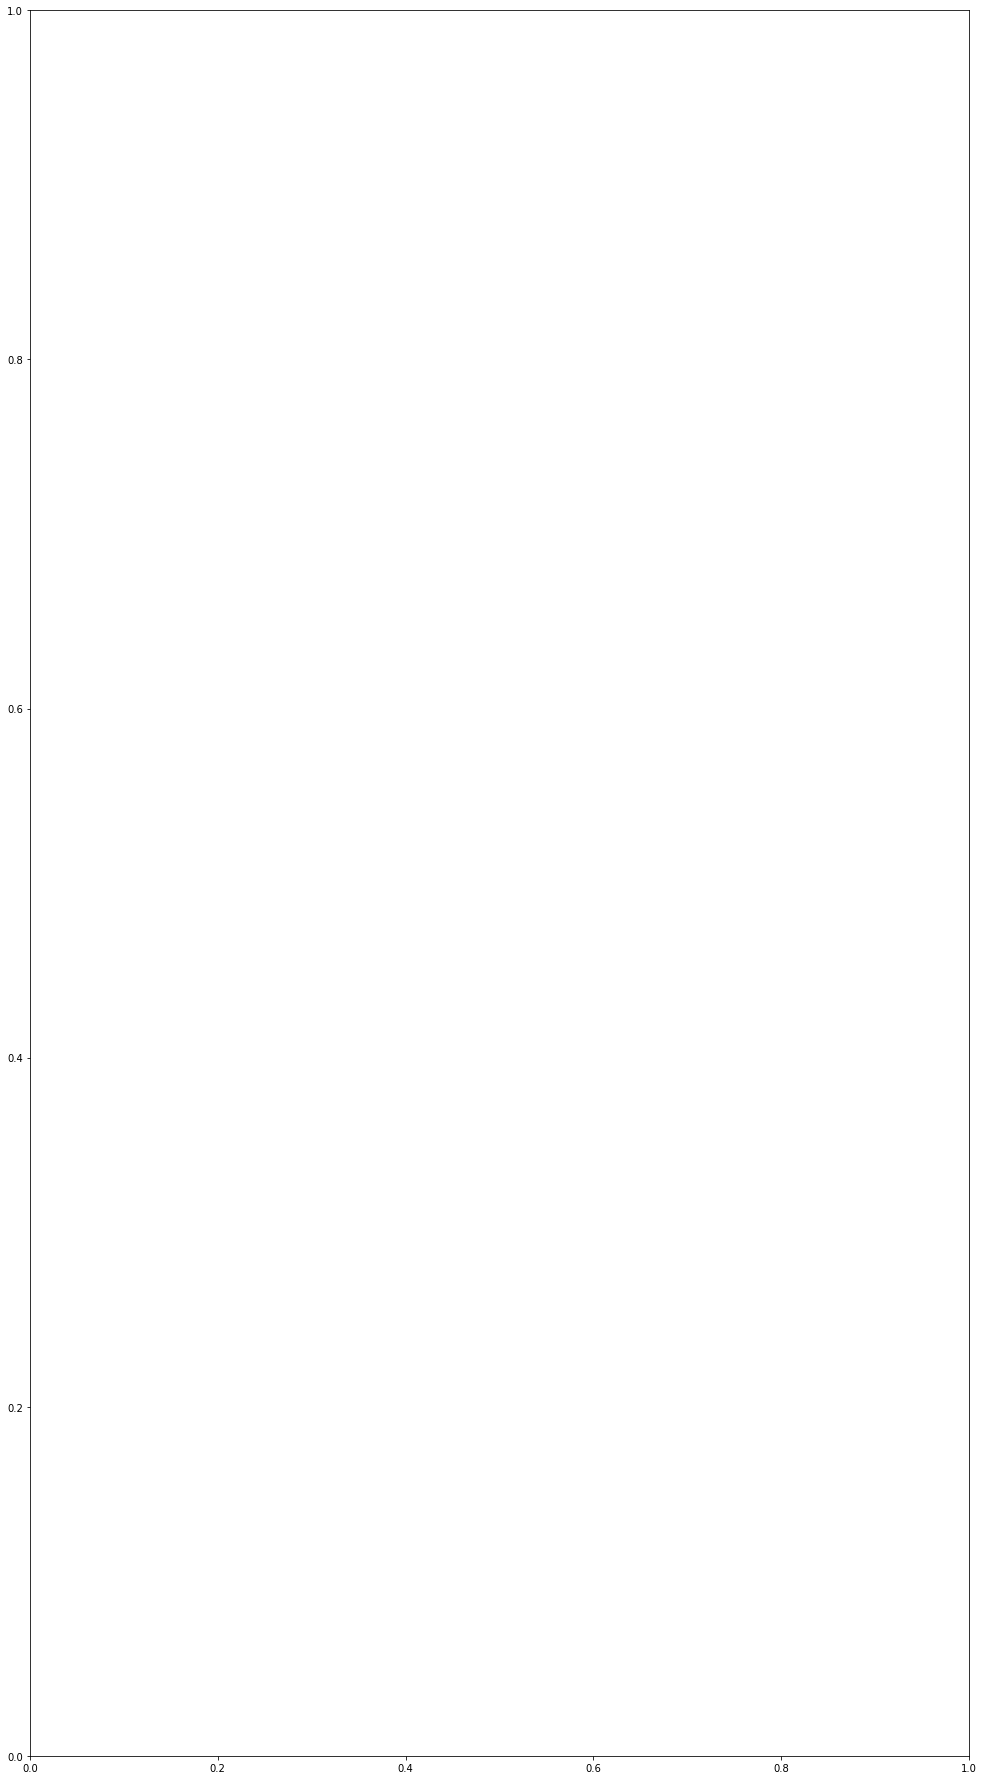

In [52]:
regions = ['all','three_prime_utrs','five_prime_utrs','cds','distintron500','proxintron500']
num_to_plot = 50

# merged_fold_changes.index = [i.replace('.clip_formatted.bed.clip_analysis.pickle','') for i in merged.index] # cleans up the labels a bit more.
def plot_zscores(df, regions, img_dir):
    for region in regions:
        df.sort_values(by=region, ascending=False, inplace=True)
        subset = df[:num_to_plot][region].dropna()
        subset = subset.iloc[::-1] # flip so that highest is on top
        subset.plot(
            kind='barh', 
            figsize=(15,25),
        )
        plt.title('Mean phastcon fold changes at least {} peaks: {}'.format(MIN_EVENTS, region))
        plt.tight_layout()
        plt.savefig(
            os.path.join(img_dir, '{}_mean_phastcon_l2_foldchanges_zscores.png'.format(region))
        )
        plt.clf()
        plt.cla()
        
plot_zscores(merged_fold_changes_z, regions, img_dir)

# look at 3'UTR conservation in TDP43

In [23]:
import pybedtools

tdp43_peaks = pd.read_table(
    '/home/elvannostrand/data/clip/CLIPseq_analysis/ENCODE_FINALforpapers_20170325/IDR/340.01v02.IDR.out.0102merged.bed.annotated',
    names=['chrom','start','end','l10p','l2fc','strand','annotation','genes']
)
utr3_bed = pybedtools.BedTool('/projects/ps-yeolab3/bay001/annotations/data/regions/hg19_three_prime_utrs.bed')
phastcon_bw = '/projects/ps-yeolab/genomes/hg19/hg19.100way.phastCons.bw'

conservation_density = ReadDensity.Phastcon(phastcon_bw)
"""
def get_region(row):
    if 'intergenic' in row['annotation']:
        return 'intergenic'
    else:
        return row['annotation'].split('|')[0]

tdp43_peaks['region'] = tdp43_peaks.apply(get_region, axis=1)
tdp43_3utr_peaks = tdp43_peaks[tdp43_peaks['region']=='3utr'][['chrom','start','end','l10p','l2fc','strand']]
peaks = pybedtools.BedTool.from_dataframe(tdp43_3utr_peaks)"""

"\ndef get_region(row):\n    if 'intergenic' in row['annotation']:\n        return 'intergenic'\n    else:\n        return row['annotation'].split('|')[0]\n\ntdp43_peaks['region'] = tdp43_peaks.apply(get_region, axis=1)\ntdp43_3utr_peaks = tdp43_peaks[tdp43_peaks['region']=='3utr'][['chrom','start','end','l10p','l2fc','strand']]\npeaks = pybedtools.BedTool.from_dataframe(tdp43_3utr_peaks)"

# Read in Pickle file

In [24]:
tdp_pickle = '/projects/ps-yeolab3/encode/analysis/encode_idr_clip_analysis/340.01v02.IDR.out.0102merged.bed.annotated.clip_formatted.bed.clip_analysis.pickle'
dataframe = get_dataframes(tdp_pickle)[0]['three_prime_utrs'][0].reset_index()
dataframe.head()

,level_0,level_1,level_2,level_3,size,covered,sum,mean0,mean
0,three_prime_utrs,real,1,"ENSG00000120948.11_5838,ENSG00000120948.11_3260_chr1:11083476-11083613",137,137,136.886,0.999168,0.999168
1,three_prime_utrs,real,1,"ENSG00000120948.11_3259,ENSG00000120948.11_3258,ENSG00000120948.11_3261_chr1:11083618-11083726",108,108,107.473,0.995120,0.995120
2,three_prime_utrs,real,1,ENSG00000120948.11_4080_chr1:11083883-11083960,77,77,76.805,0.997468,0.997468
3,three_prime_utrs,real,1,ENSG00000028137.12_1382_chr1:12268458-12268558,100,100,0.410,0.004100,0.004100
4,three_prime_utrs,real,1,ENSG00000028137.12_1549_chr1:12269166-12269263,97,97,14.320,0.147629,0.147629


# Parse pickle file column to get peak coords
- careful, strand isn't stored (but we don't care i think)

In [25]:
dataframe['pos'] = dataframe['level_3'].apply(lambda x: x.split('_')[-1])
dataframe['chrom'] = dataframe['pos'].apply(lambda x: x.split(':')[0])
dataframe['start'] = dataframe['pos'].apply(lambda x: int(x.split(':')[1].split('-')[0]))
dataframe['end'] = dataframe['pos'].apply(lambda x: int(x.split(':')[1].split('-')[1]))
dataframe = dataframe[['chrom','start','end','sum','mean']]
dataframe['strand'] = '+' # ignore strand for now
dataframe.head()

,chrom,start,end,sum,mean,strand
0,chr1,11083476,11083613,136.886,0.999168,+
1,chr1,11083618,11083726,107.473,0.995120,+
2,chr1,11083883,11083960,76.805,0.997468,+
3,chr1,12268458,12268558,0.410,0.004100,+
4,chr1,12269166,12269263,14.320,0.147629,+


# Overlap Phastcon scores across length of peak (+/- 100nt up and downstream)

In [26]:
hg19chromsizes = '/projects/ps-yeolab/genomes/hg19/hg19.chrom.sizes'
peaks = pybedtools.BedTool.from_dataframe(dataframe)
flanking_regions = peaks.flank(g=hg19chromsizes, b=100).to_dataframe()

def return_avg_phastcon(row, density=conservation_density):
    lst = density.values(
        row['chrom'], row['start'], row['end'], row['strand']
    )
    return sum(lst) / float(len(lst))

flanking_regions['score'] = flanking_regions.apply(return_avg_phastcon, axis=1)

In [27]:
add_left_flank = pd.merge(flanking_regions, dataframe, how='right', left_on='end', right_on='start')
add_left_flank.columns = ['left_chrom','left_start','left_end','left_name','left_score','left_strand',
                         'chrom','start','end','name','score','strand']
add_right_flank = pd.merge(add_left_flank, flanking_regions, how='left', left_on='end', right_on='start')

In [28]:
add_right_flank['what'] = add_right_flank['left_score'] + add_right_flank['score_y'] - add_right_flank['score_x']

In [29]:
out_file = '/home/bay001/projects/encode/analysis/conservation_analysis/analysis_from_pickle/340_tdp43_conserved_3utr_candidates.bed'
add_right_flank.sort_values(by='what').head(30)[['chrom_x','start_x','end_x']].to_csv(out_file, sep='\t', index=False, header=False)

In [56]:
add_right_flank.sort_values(by='what', ascending=True).head(30)

,left_chrom,left_start,left_end,left_name,left_score,left_strand,chrom_x,start_x,end_x,name_x,score_x,strand_x,chrom_y,start_y,end_y,name_y,score_y,strand_y,what
383,chr7,150841359,150841459,59.541,0.33881,+,chr7,150841459,150841525,59.541,0.902136,+,chr7,150841525,150841625,59.541,0.00009,+,-0.563236
346,chr6,34555373,34555473,95.567,0.09905,+,chr6,34555473,34555610,95.567,0.697569,+,chr6,34555610,34555710,95.567,0.03747,+,-0.561049
267,chr22,39886606,39886706,77.223,0.07904,+,chr22,39886706,39886823,77.223,0.660026,+,chr22,39886823,39886923,77.223,0.17960,+,-0.401386
252,chr20,54944616,54944716,44.864,0.00495,+,chr20,54944716,54944803,44.864,0.515678,+,chr20,54944803,54944903,44.864,0.12405,+,-0.386678
40,chr1,158580748,158580848,41.027,0.03410,+,chr1,158580848,158580958,41.027,0.372973,+,chr1,158580958,158581058,41.027,0.01686,+,-0.322013
228,chr19,55741056,55741156,52.449,0.01986,+,chr19,55741156,55741221,52.449,0.806908,+,chr19,55741221,55741321,52.449,0.46943,+,-0.317618
35,chr1,118169221,118169321,44.805,0.27833,+,chr1,118169321,118169392,44.805,0.631056,+,chr1,118169392,118169492,44.805,0.03898,+,-0.313746
50,chr1,206907452,206907552,54.526,0.23894,+,chr1,206907552,206907612,54.526,0.908767,+,chr1,206907612,206907712,54.526,0.36484,+,-0.304987
80,chr10,120927316,120927416,42.750,0.06581,+,chr10,120927416,120927510,42.750,0.454787,+,chr10,120927510,120927610,42.750,0.09003,+,-0.298947
288,chr3,128338717,128338817,22.890,0.10405,+,chr3,128338817,128338863,22.890,0.497609,+,chr3,128338863,128338963,22.890,0.12018,+,-0.273379
